In [64]:
#准备资料
import numpy as np
import matplotlib.pyplot as plt
x_train_data='/home/zjy/ml hw2/data/X_train'
y_train_data='/home/zjy/ml hw2/data/Y_train'
x_test_data='/home/zjy/ml hw2/data/X_test'
output_data='/home/zjy/ml hw2/data/discriminative_output.csv'
np.random.seed(0) #使后面生成的随机数相同

with open(x_train_data) as f1:
    next(f1) #跳过第一行，从第二行开始读，第一行是features名称
    X_train=np.array([line.strip('\n').split(',')[1:] for line in f1],dtype=float)
    #strip('\n')表示删掉每行数据中的换行符，split(',')以每行中逗号作数据分隔，每行从下标为1的数据读起，因下标为0的是id号
    
with open(y_train_data) as f2:
    next(f2)
    Y_train=np.array([line.strip('\n').split(',')[1] for line in f2],dtype=float) #只读下标1列，即表示类别0还是1的列
    
with open(x_test_data) as f3:
    next(f3)
    X_test=np.array([line.strip('\n').split(',')[1:] for line in f3],dtype=float)

In [65]:
#定义各种函数
def normalize(X,train=True,column_id=None,X_mean=None,X_std=None):
#该函数用于对矩阵X做正则化操作，train为true时代表处理的是training data，为false时是testing data，由于对X_test的正则化也是依靠X_test的mean和
#std，所以为false时直接使用之前算得的mean，std。column_id是索引每个要正则化的列，是一个数，若为none返回一个数，不为none表示求所有列的mean和std，
#并返回1*n的矩阵
    eps=1e-10 #防止分母为0
    if column_id==None:
        column_id=np.arange(X.shape[1])
    if train== True:
        X_mean=np.mean(X[:,column_id],0).reshape(1,-1)
        X_std=np.std(X[:, column_id],0).reshape(1,-1)
    X[:,column_id]=(X[:,column_id]-X_mean)/(X_std+eps)
    return X,X_mean,X_std

def val_split(X,Y,val_ratio=0.1):
#在X_trian中按照9：1划分训练集和验证集
    train_size=int(len(X)*(1-val_ratio))
    X_train=X[:train_size]
    Y_train=Y[:train_size]
    X_val=X[train_size:]
    Y_val=Y[train_size:]
    return X_train,Y_train,X_val,Y_val

def shuffleX(X,Y):
#打乱行顺序的函数，只使各行顺序发生改变
    randomize=np.arange(len(X))
    np.random.shuffle(randomize) #由于上行randomize已与X的每行的下标绑定，故randomize中的元素顺序改变，X的行下标也跟着变
    return (X[randomize],Y[randomize])

def f(X,w,b):
#定义通过sigmoid函数得到预测结果并取整
    z=np.matmul(X,w)+b #matmul矩阵相乘
    sigmoid=np.clip(1/(1.0+np.exp(-z)),1e-10,1-(1e-10)) #clip是将大于1的数变成1，将小于0的数变成0
    return sigmoid

def predict(X,w,b):
    return np.round(f(X,w,b)).astype(np.int) #对预测结果取整数

def accuracy(Y_pred,Y_label):
#算predict值和label值的准确率
    return 1-np.mean(np.abs(Y_pred-Y_label)) #值越接近1预测越准确

def cross_entropy_loss(Y_pred,Y_label):
#用交叉熵来当loss
    cross_entropy=-np.dot(Y_label,np.log(Y_pred))-np.dot((1-Y_label),np.log(1-Y_pred))
    return cross_entropy

def gradient(X,Y_label,w,b):
#定义gradient descent中的w和b以便后续调用
    w_grad=-np.sum((Y_label-f(X,w,b))*X.T,1)
    b_grad=-np.sum(Y_label-f(X,w,b))
    return w_grad,b_grad

In [66]:
#初始化
#对X_train,X_test进行正则化
X_train,X_mean,X_std=normalize(X_train,train=True)
X_test,_,_=normalize(X_test,train=False,column_id=None,X_mean=X_mean,X_std=X_std) #单下划线作为临时变量名
#每次迭代都用shuffleX把数据行打乱，然后再分成多个小批次计算梯度及损失，并更新参数，进行下一次循环，直到iter_time的迭代次数完成
w=np.zeros([X_train.shape[1],])
b=np.zeros([1,])
iter_time=10 #迭代总次数
batch_size=8 #mini-batch training时用到的一小笔数据长度
learning_rate=0.2
#划分训练集
val_ratio=0.1
X_train,Y_train,X_val,Y_val=val_split(X_train,Y_train,val_ratio=val_ratio)
#创建多个空列表保存迭代时的loss和accuracy，后面通过append往里面加数据，然后直接用这个列表来画图
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]

In [67]:
#Training
step_time=1 #计算次数，用于后面learning_rate随迭代次数衰减
for time in range(iter_time):
    X_train, Y_train=shuffleX(X_train,Y_train)
    for batch in range(int(np.floor(X_train.shape[0]/batch_size))):
        X=X_train[batch*batch_size:(batch+1)*batch_size]
        Y=Y_train[batch*batch_size:(batch+1)*batch_size]
        w_grad,b_grad=gradient(X,Y,w,b)
        w=w-learning_rate/np.sqrt(step_time)*w_grad
        b=b-learning_rate/np.sqrt(step_time)*b_grad #w和b的learning_rate衰减
        step_time=step_time+1
    #分别计算training data和validation data的loss和accuracy
    y_train_pred=f(X_train,w,b) #loss中用
    Y_train_pred=np.round(y_train_pred) #acc中用
    train_acc.append(accuracy(Y_train_pred,Y_train))
    train_loss.append(cross_entropy_loss(y_train_pred,Y_train)/X_train.shape[0]) #用取round后的Y_train_pred得到的值会是nan？
    
    y_val_pred=f(X_val,w,b)
    Y_val_pred=np.round(y_val_pred)
    val_acc.append(accuracy(Y_val_pred,Y_val))
    val_loss.append(cross_entropy_loss(y_val_pred,Y_val)/X_val.shape[0])

print('Training loss:{}'.format(train_loss[-1]))
print('Validation loss:{}'.format(val_loss[-1]))
print('Training accuracy:{}'.format(train_acc[-1]))
print('Validation accuracy:{}'.format(val_acc[-1]))

Training loss:0.27158325078425083
Validation loss:0.2896359739296746
Training accuracy:0.8836166291214418
Validation accuracy:0.8733873940287504


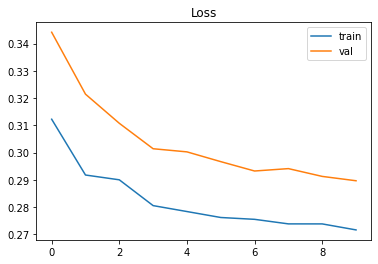

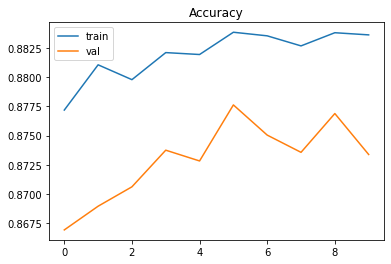

In [68]:
#用matplotlib分别画出loss曲线和accuracy曲线
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.legend(['train','val'])
plt.savefig('loss.png')
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.legend(['train','val'])
plt.savefig('acc.png')
plt.show()

In [69]:
#将结果写入csv文件
pred=predict(X_test,w,b)
with open(output_data,'w')as f:
    f.write('id,label\n')
    for i,label in enumerate(pred): #enumerate能同时遍历出pred的索引和元素
        f.write('{},{}\n'.format(i,label))

/tmp/ipykernel_6702/103976939.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.round(f(X,w,b)).astype(np.int) #对预测结果取整数
